In [1]:
from utils.all import *

data = load_data('../data/inspection_rating_annotated', preprocess=True, adjudicated=True)
systems = set([x['system'] for x in data])
edit_types = set(data[0]['annotations'].keys())

In [2]:
not_human = [s for s in data if 'Human' not in s['system']]

all_edits = [i for j in [s['processed_annotations'] for s in not_human] for i in j]
error_edits = [e for e in all_edits if e['error_type'] != None]

print(f'% all edits that are errors: {(len(error_edits)/len(all_edits)):.2f}')

% all edits that are errors: 0.14


In [3]:
human = [s for s in data if 'Human' in s['system']]
gpt_few = [s for s in data if 'few' in s['system']]
gpt_zero = [s for s in data if 'zero' in s['system']]
muss = [s for s in data if 'Muss' in s['system']]

# Percent of all sentences that contain an error
def error_rate(data, exclude_bad_deletion=False):
    count = 0
    if exclude_bad_deletion:
        for s in data:
            if any([e['error_type'] != None and e['error_type'] != Error.BAD_DELETION for e in s['processed_annotations']]):
                count += 1
    else:
        for s in data:
            if any([e['error_type'] != None for e in s['processed_annotations']]):
                count += 1
    return count / len(data)


all_edits = [i for j in [s['processed_annotations'] for s in data] for i in j]
error_edits = [e for e in all_edits if e['error_type'] != None]

print(f'% all edits that are errors: {(len(error_edits)/len(all_edits)):.2f}')
print(f'Error rate for all systems: {error_rate(data):.2f}')
print(f'Error rate for MUSS: {error_rate(muss):.2f}')
print(f'Error rate for GPT-zero: {error_rate(gpt_zero):.2f}')
print(f'Error rate for human/GPT-few: {error_rate(human):.2f} / {error_rate(gpt_few):.2f}')
print(f'Error rate for human/GPT-few excluding bad deletion: {error_rate(human, exclude_bad_deletion=True):.2f} / {error_rate(gpt_few, exclude_bad_deletion=True):.2f}')

% all edits that are errors: 0.13
Error rate for all systems: 0.50
Error rate for MUSS: 0.64
Error rate for GPT-zero: 0.67
Error rate for human/GPT-few: 0.48 / 0.62
Error rate for human/GPT-few excluding bad deletion: 0.31 / 0.53


In [4]:
# Find sentences with a specific type of error
total, found = 0, 0
for sent in data:
    if 'Muss' not in sent['system']:
        continue

    selected = [a for a in sent['processed_annotations'] if 
        a['information_impact'] == Information.MORE
    ]

    found += len([a for a in selected if a['error_type'] != None])
    total += len(selected)
print(found/total)

0.25


In [5]:
# Find sentences with a specific type of error
for sent in data:
    if 'GPT-3-few-shot' not in sent['system']:
        continue

    errors = [a for a in sent['processed_annotations'] if a['error_type'] is not None]
    selected = [a for a in errors if 
        a['error_type'] != None and
        a['error_type'] not in [Error.BAD_DELETION, Error.COREFERENCE] and
        a['family'] == Family.CONTENT and
        a['rating'] == 2
    ]

    if len(selected) != 0:
        print(get_sent_info(sent))

ayush - Batch 1, HIT 193 (ID 276)


In [6]:
for sent in data:
    if "They imposed" in sent['simplified']:
        print(get_sent_info(sent))
        print(sent['system'])

ayush - Batch 1, HIT 159 (ID 174)
new-wiki-1/GPT-3-few-shot
vinayak - Batch 2, HIT 159 (ID 175)
new-wiki-1/GPT-3-few-shot
vishnesh - Batch 2, HIT 159 (ID 176)
new-wiki-1/GPT-3-few-shot


In [7]:
# Find an example sentence
found = []
for sent in data:
    if 'GPT-3-few-shot' not in sent['system']:
        continue 

    errors = [a for a in sent['processed_annotations'] if a['error_type'] is not None]

    # Aim for 2-4 errors
    if len(errors) < 2:
        continue

    # Exclude longer sentences
    if len(sent['original']) > 200:
        continue

    print(get_sent_info(sent))
    found += [sent]

# Our Winner is: anton - Batch 7, HIT 23 (ID 170)
example = found[2]
print(get_sent_info(found[2]))

print(f"Average score: {avg([avg(x.values()) for x in example['da_scores']])}")

ayush - Batch 1, HIT 124 (ID 69)
vinayak - Batch 1, HIT 124 (ID 70)
vishnesh - Batch 1, HIT 124 (ID 71)
vinayak - Batch 1, HIT 129 (ID 85)
vinayak - Batch 2, HIT 159 (ID 175)
vishnesh - Batch 2, HIT 159 (ID 176)
rachel - Batch 1, HIT 56 (ID 585)
vinayak - Batch 1, HIT 56 (ID 586)
vishnesh - Batch 1, HIT 56 (ID 587)
vinayak - Batch 2, HIT 344 (ID 1031)
vinayak - Batch 3, HIT 501 (ID 1240)
vinayak - Batch 3, HIT 406 (ID 1576)
vishnesh - Batch 3, HIT 406 (ID 1577)
vinayak - Batch 3, HIT 437 (ID 1669)
rachel - Batch 3, HIT 458 (ID 1731)
vinayak - Batch 3, HIT 458 (ID 1732)
vinayak - Batch 3, HIT 475 (ID 1783)
vinayak - Batch 4, HIT 639 (ID 1916)
vinayak - Batch 4, HIT 658 (ID 1973)
rachel - Batch 4, HIT 670 (ID 2008)
vinayak - Batch 4, HIT 670 (ID 2009)
ayush - Batch 4, HIT 686 (ID 2055)
vinayak - Batch 4, HIT 686 (ID 2057)
vishnesh - Batch 1, HIT 124 (ID 71)
Average score: 74.44


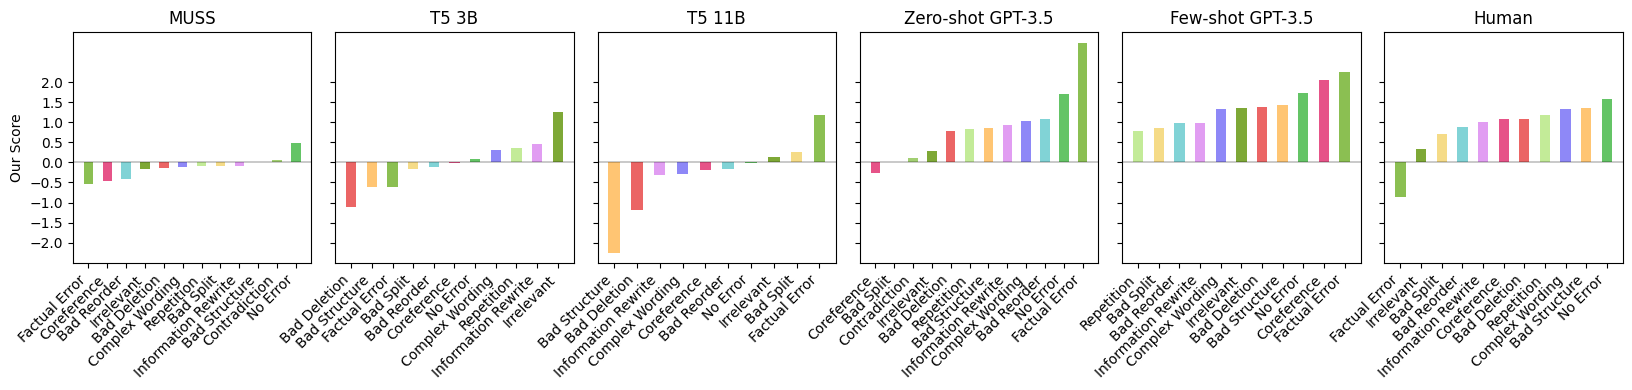

In [18]:
class Tmp(Enum):
    NO_ERROR = 'No Error'

cust_systems = [s for s in systems if 'Human' not in s] + ['aggregated/human']

fig, ax = plt.subplots(1, len(cust_systems), figsize=(20, 3), sharey=True, gridspec_kw = {'wspace': 0.1, 'hspace':0})
for i, system in enumerate([s for s in all_system_labels if s in cust_systems]):
    selected = [sent for sent in data if sent['system'] == system]
    if system == 'aggregated/human':
        selected = [sent for sent in data if 'Human' in sent['system']]

    error_segmentation = {}
    for error in Error:
        error_segmentation[error] = [sent for sent in selected if any([ann['error_type'] == error for ann in sent['processed_annotations']])]
    error_segmentation[Tmp.NO_ERROR] = [sent for sent in selected if not any([ann['error_type'] == error for ann in sent['processed_annotations']])]

    pts = []
    pts += [(error, avg([s['score'] for s in error_segmentation[error]])) for error in error_segmentation.keys()]
    pts = sorted([p for p in pts if p[1] != 0], key=lambda x: x[1])

    cust_mapping = color_mapping
    cust_mapping[Tmp.NO_ERROR] = '#64C466'

    ax[i].axhline(0, linestyle='-', color='black', linewidth=0.3) 

    ax[i].bar([p[0].value for p in pts], [p[1] for p in pts], width, color=[cust_mapping[label] for label in [p[0] for p in pts]])
    ax[i].set_title(system_name_mapping[system])
    # ax[i].set_xticks([])
    ax[i].set_yticks(np.arange(-2, 2.5, 0.5))


for tick in [i for j in [x.get_xticklabels() for x in ax] for i in j]:
    tick.set_rotation(45)
    tick.set_horizontalalignment('right')

# fig.suptitle('Avg. Error Sent Scores')
ax[0].set_ylabel('Our Score')
# plt.legend([p[0].value for p in pts], loc='center left', bbox_to_anchor=(1.5, 0.5), ncol=3)
out_filename = f'../paper/plot/appendix/error-scores.pdf'
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show()

In [9]:
get_comments(data)

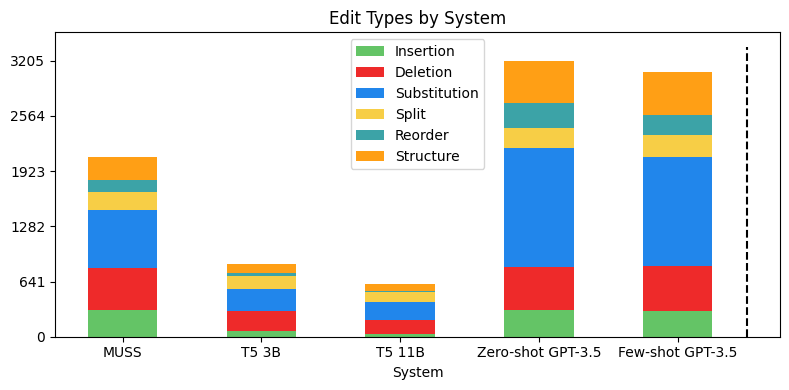

In [10]:
edit_type_by_system(data)

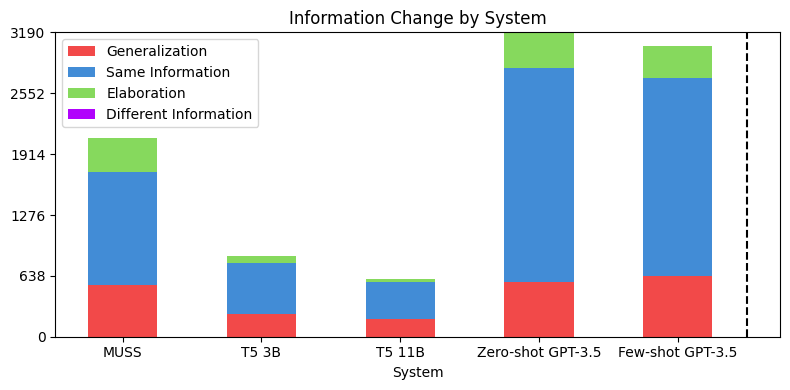

In [11]:
system_by_information_change(data)

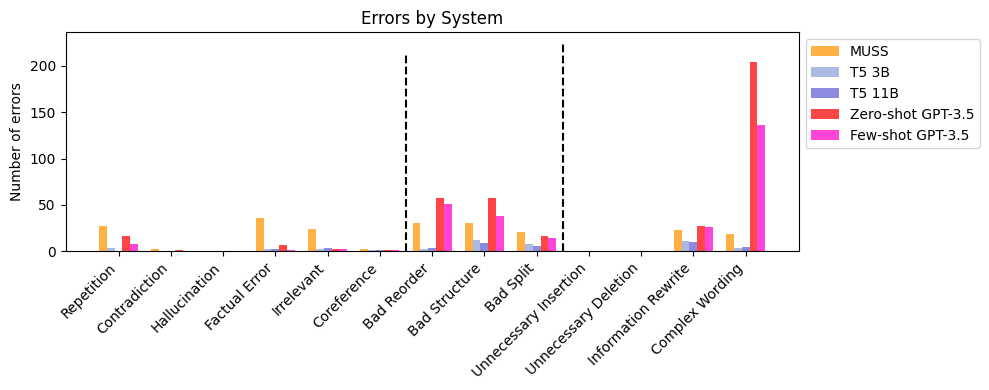

In [12]:
errors_by_system(data)

In [13]:
sankey_combined(data)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
# & -- & -- & -- & -- & -- & -- & -- & -- \tabularnewline

# Print the avg. sentence scores for each system
table = ''

subscores = ['lexical', 'syntax', 'content', 'error', 'quality']

std = lambda x: round(np.std(x, ddof=1), 2)

for system in [s for s in all_system_labels if s in systems and 'Human' not in s] + ['aggregated/human']:
    selected = [sent for sent in data if sent["system"] == system]
    if system == 'aggregated/human':
        selected = [sent for sent in data if 'Human' in sent['system']]

    line = f'{system_name_mapping[system]} & '

    for score in subscores:
        selected_scores = [s["subscores"][score] for s in selected]
        line += f'{avg(selected_scores, 2):.2f} & {std(selected_scores):.2f} & '

    selected_scores = [s["score"] for s in selected]
    line += f'{avg(selected_scores, 2):.2f} & {std(selected_scores):.2f}'

    table += f'{line} \\tabularnewline\n'
print(table)

MUSS & 0.81 & 1.23 & 0.45 & 0.64 & 0.97 & 1.73 & 0.66 & 1.03 & 1.00 & 1.04 & 1.77 & 1.66 \tabularnewline
T5 3B & 0.24 & 0.56 & 0.18 & 0.38 & 0.65 & 1.92 & 0.34 & 0.97 & 0.39 & 0.62 & 0.76 & 1.15 \tabularnewline
T5 11B & 0.22 & 0.44 & 0.17 & 0.92 & 0.61 & 1.78 & 0.36 & 1.30 & 0.32 & 0.71 & 0.71 & 1.51 \tabularnewline
Zero-shot GPT-3.5 & 1.32 & 1.40 & 0.67 & 0.65 & 0.17 & 0.38 & 0.34 & 0.53 & 1.75 & 1.55 & 2.10 & 1.60 \tabularnewline
Few-shot GPT-3.5 & 1.41 & 1.43 & 0.57 & 0.53 & 0.15 & 0.39 & 0.25 & 0.46 & 1.80 & 1.49 & 2.11 & 1.60 \tabularnewline
Human & 1.25 & 1.85 & 0.60 & 0.86 & 0.32 & 0.83 & 0.25 & 0.62 & 1.67 & 1.64 & 2.04 & 2.16 \tabularnewline



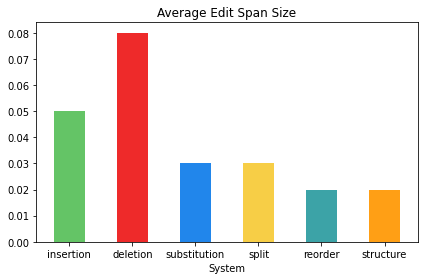

In [ ]:
annotations = [x for y in [sent['processed_annotations'] for sent in data] for x in y]
avg_span_size(annotations)

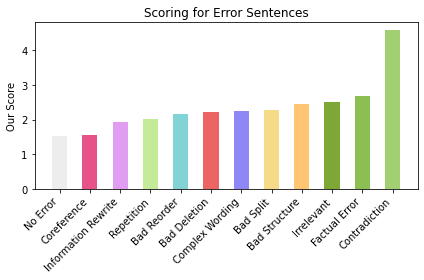

In [ ]:
class Tmp(Enum):
    NO_ERROR = 'No Error'

error_segmentation = {}
for error in Error:
    error_segmentation[error] = [sent for sent in data if any([ann['error_type'] == error for ann in sent['processed_annotations']])]
error_segmentation[Tmp.NO_ERROR] = [sent for sent in data if not any([ann['error_type'] == error for ann in sent['processed_annotations']])]

pts = []
pts += [(error, avg([s['score'] for s in error_segmentation[error]])) for error in error_segmentation.keys()]
pts = sorted([p for p in pts if p[1] != 0], key=lambda x: x[1])

fig, ax = plt.subplots(figsize=(6, 4))

cust_mapping = color_mapping
cust_mapping[Tmp.NO_ERROR] = '#ededed'

ax.bar([p[0].value for p in pts], [p[1] for p in pts], width, color=[cust_mapping[label] for label in [p[0] for p in pts]])
plt.xticks(rotation=45, ha="right")
ax.set_ylabel('Our Score')
ax.set_title('Scoring for Error Sentences')
plt.show()

In [ ]:
def get_annotations_by_edit_family(data, edit_type):
    information_change = None
    if edit_type == 'paraphrase':
        family = Family.LEXICAL
        edit_type = 'substitution'
    elif edit_type == 'split' or edit_type == 'structure' or edit_type == 'reorder':
        family = Family.SYNTAX
    elif edit_type == 'elaboration' or edit_type == 'generalization':
        family = Family.CONTENT
        if edit_type == 'elaboration':
            information_change = Information.MORE
        elif edit_type == 'generalization':
            information_change = Information.LESS
    else:
        raise ValueError(f'Edit type not supported for this operation: {edit_type}')

    anns = [ann for sent in data for ann in sent['processed_annotations']]
    selected = [ann for ann in anns if ann['family'] == family and ann['edit_type'] == edit_type]
    if edit_type == 'elaboration' or edit_type == 'generalization':
        selected = [ann for ann in anns if ann['information_impact'] == information_change]

    return selected

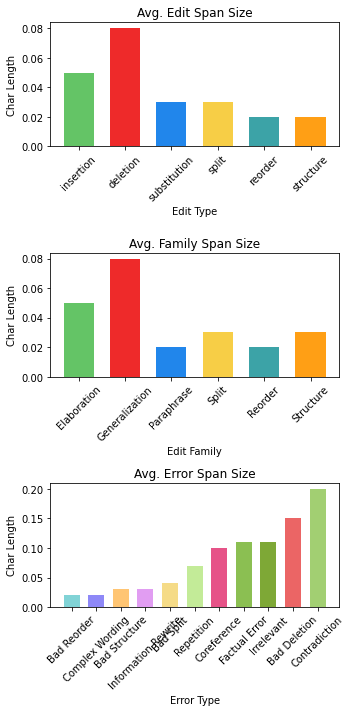

In [ ]:
families = [
    'elaboration',
    'generalization',
    'paraphrase',
    'split',
    'reorder',
    'structure',
]

class Tmp(Enum):
    NO_ERROR = 'No Error'

width = 0.65
annotations = [x for y in [sent['processed_annotations'] for sent in data] for x in y]
fig, ax = plt.subplots(3, 1, figsize=(5, 10))

edit_size = [avg([x['size'] for x in annotations if x['edit_type'] == edit_type]) for edit_type in edit_type_labels]
ax[0].bar(edit_type_labels, edit_size, width, color=[color_mapping[label] for label in edit_type_labels])

fam_size = [avg([x['size'] for x in get_annotations_by_edit_family(data, family)]) for family in families]
ax[1].bar([x.capitalize() for x in families], fam_size, width, color=[color_mapping[label] for label in families])

anns = [ann for sent in data for ann in sent['processed_annotations']]
error_segmentation = {}
for error in Error:
    error_segmentation[error] = [a for a in anns if error == a['error_type']]
error_segmentation[Tmp.NO_ERROR] = [a for a in anns if error == None]
pts = []
pts += [(error, avg([s['size'] for s in error_segmentation[error]])) for error in error_segmentation.keys()]
pts = sorted([p for p in pts if p[1] != 0], key=lambda x: x[1])
ax[2].bar([p[0].value for p in pts], [p[1] for p in pts], width, color=[color_mapping[label] for label in [p[0] for p in pts]])

ax[0].set_xlabel('Edit Type')
ax[1].set_xlabel('Edit Family')
ax[2].set_xlabel('Error Type')

ax[0].set_ylabel('Char Length')
ax[1].set_ylabel('Char Length')
ax[2].set_ylabel('Char Length')

ax[0].set_title('Avg. Edit Span Size')
ax[1].set_title('Avg. Family Span Size')
ax[2].set_title('Avg. Error Span Size')

for tick in ax[0].get_xticklabels() + ax[1].get_xticklabels() + ax[2].get_xticklabels():
    tick.set_rotation(45)
plt.show()

DEBUG:Assigning font /F1 = 'C:\\Users\\heine\\miniconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'
DEBUG:Embedding font C:\Users\heine\miniconda3\Lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans.ttf.
DEBUG:Writing TrueType font.


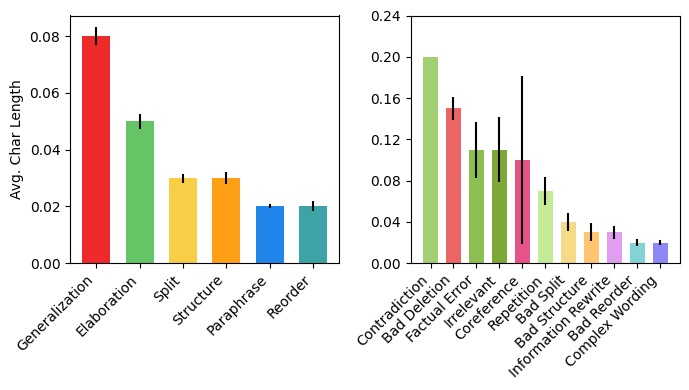

In [ ]:
families = [
    'elaboration',
    'generalization',
    'paraphrase',
    'split',
    'reorder',
    'structure',
]

class Tmp(Enum):
    NO_ERROR = 'No Error'

import scipy.stats as st
def ci(int_data):
    y1, y2 = st.t.interval(alpha=0.95, df=len(int_data)-1, loc=np.mean(int_data), scale=st.sem(int_data)) 
    # If it's too big, we just won't even return it
    if y1 <= 0.01 or math.isnan(y1):
        return 0
    return (y2-y1) / 2

width = 0.65
annotations = [x for y in [sent['processed_annotations'] for sent in data] for x in y]
fig, ax = plt.subplots(1, 2, figsize=(7, 4))

fam_size = [(family, avg([x['size'] for x in get_annotations_by_edit_family(data, family)]), ci([x['size'] for x in get_annotations_by_edit_family(data, family)])) for family in families]
pts = sorted([p for p in fam_size if p[1] != 0], key=lambda x: x[1], reverse=True)
ax[0].bar([p[0].capitalize() for p in pts], [p[1] for p in pts], width, yerr=[p[2] for p in pts], color=[color_mapping[label] for label in [p[0] for p in pts]])

anns = [ann for sent in data for ann in sent['processed_annotations']]
error_segmentation = {}
for error in Error:
    error_segmentation[error] = [a for a in anns if error == a['error_type']]
error_segmentation[Tmp.NO_ERROR] = [a for a in anns if error == None]
pts = [(error, avg([s['size'] for s in error_segmentation[error]]), ci([s['size'] for s in error_segmentation[error]])) for error in error_segmentation.keys()]
pts = sorted([p for p in pts if p[1] != 0], key=lambda x: x[1], reverse=True)
ax[1].bar([p[0].value for p in pts], [p[1] for p in pts], width, yerr=[p[2] for p in pts], color=[color_mapping[label] for label in [p[0] for p in pts]])

# ax[0].set_xlabel('Edit Family')
# ax[1].set_xlabel('Error Type')

ax[0].set_ylabel('Avg. Char Length')
ax[1].set_ylabel('')

# plt.suptitle('Avg. Edit Span Size by Type')
# ax[1].set_title('Avg. Error Span Size')

ax[0].set_yticks(np.arange(0, 0.085, 0.02))
ax[1].set_yticks(np.arange(0, 0.25, 0.04))

for tick in ax[0].get_xticklabels() + ax[1].get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment('right')

out_filename = f'../paper/plot/appendix/edit-sizes.pdf'
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show()

NameError: name 'asset' is not defined

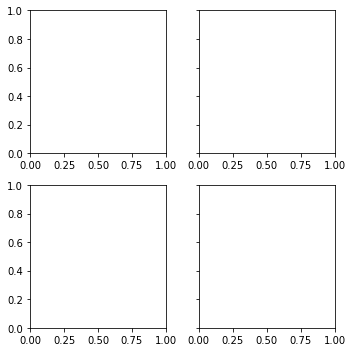

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(5, 5), sharey=True)

# If a bucket has less than this value, we don't include it
representative_sample_size = 25

for k, dataset in enumerate([data, asset]):
    bucket_size = 20
    start_amt = 0
    end_amt = 205
    pts = {}
    for i in range((end_amt - start_amt) // bucket_size):
        start_size = start_amt + i * bucket_size
        end_size = start_amt + (i + 1) * bucket_size

        selected = [s for s in dataset if start_size <= s['ed'] < end_size]

        amt_splits = {}
        for amt in range(1, 4):
            if amt not in amt_splits.keys():
                amt_splits[amt] = 0
            for sent in selected:
                if len([a for a in sent['edits'] if a['type'] == 'split']) == amt:
                    amt_splits[amt] += 1
        
        for amt in range(1, 4):
            if amt not in pts.keys():
                pts[amt] = []
            if len(selected) > representative_sample_size:
                pts[amt] += [(start_size, amt_splits[amt] / len(selected))]
            else:
                pts[amt] += [(start_size, 0)]
    bottom = [0 for _ in range(len(pts[1])-1)]
    for amt in range(1, 4):
        val = [p[1] for p in pts[amt][1:]]
        ax[k, 0].hist([p[0] for p in pts[amt]][:-1], [p[0] for p in pts[amt]], 
            bottom=bottom, weights=[p[1] for p in pts[amt][1:]], 
            color=color_mapping[f'split-{amt}'], edgecolor='black', linewidth=1.2)
        bottom = [b + p for b, p in zip(bottom, val)]


    bucket_size = 20
    start_amt = 75
    end_amt = 300
    pts = {}
    for i in range((end_amt - start_amt) // bucket_size):
        start_size = start_amt + i * bucket_size
        end_size = start_amt + (i + 1) * bucket_size

        selected = [s for s in dataset if start_size <= len(s['simplified']) < end_size]

        amt_splits = {}
        for amt in range(1, 4):
            if amt not in amt_splits.keys():
                amt_splits[amt] = 0
            for sent in selected:
                if len([a for a in sent['edits'] if a['type'] == 'split']) == amt:
                    amt_splits[amt] += 1
        
        for amt in range(1, 4):
            if amt not in pts.keys():
                pts[amt] = []
            if len(selected) > representative_sample_size:
                pts[amt] += [(start_size, amt_splits[amt] / len(selected))]
            else:
                pts[amt] += [(start_size, 0)]
    bottom = [0 for _ in range(len(pts[1])-1)]
    for amt in range(1, 4):
        val = [p[1] for p in pts[amt][1:]]
        ax[k, 1].hist([p[0] for p in pts[amt]][:-1], [p[0] for p in pts[amt]], 
            bottom=bottom, weights=[p[1] for p in pts[amt][1:]], 
            color=color_mapping[f'split-{amt}'], edgecolor='black', linewidth=1.2)
        bottom = [b + p for b, p in zip(bottom, val)]

# fig.suptitle('Proportion of Sentences with a Split Edit')
ax[0, 0].set_xticks([])
ax[0, 1].set_xticks([])
ax[1, 0].set_xlabel('Edit Distance')
ax[1, 1].set_xlabel('Original Sentence Length')
ax[0, 0].set_ylabel('% SimpEval w/ Split')
ax[1, 0].set_ylabel('% ASSET w/ Split')
ax[0, 0].set_yticks(np.arange(0, 1.1, 0.2))

fig.legend(labels=[
        '1 Split',
        '2 Splits',
        '3 Splits',
    ], loc='lower center', bbox_to_anchor=(0.54, -0.06), framealpha=1, frameon=False,
    handlelength=1, handleheight=1, ncol=3, handletextpad=0.5, columnspacing=0.7
)

out_filename = f'../paper/plot/appendix/split-edit-sizes.pdf'
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show()

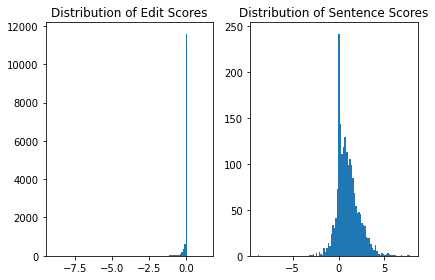

In [ ]:
# Show the distribution of edit and sentence scores
score_distribution(data)

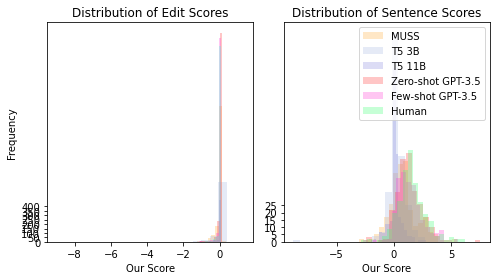

In [ ]:
import random

n_bins = 20
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(7, 4))

for system in [s for s in all_system_labels if s in systems and 'Human' not in s]:
    annotations = sorted([x for y in [sent['processed_annotations'] for sent in data if sent['system'] == system] for x in y], key=lambda x: x['score'])
    axs[0].hist([x['score'] for x in annotations], bins=n_bins, alpha=0.3, label=system_name_mapping[system], color=color_mapping[system])
    axs[1].hist([x['score'] for x in data if x['system'] == system], bins=n_bins, alpha=0.3, label=system_name_mapping[system], color=color_mapping[system])

# Only human annotations
annotations = sorted([x for y in [sent['processed_annotations'] for sent in data if 'Human' in sent['system']] for x in y], key=lambda x: x['score'])
edit_scores, sent_scores = [x['score'] for x in annotations], [x['score'] for x in data if 'Human' in x['system']]
axs[0].hist(random.sample(edit_scores, int(len(edit_scores)/2)), bins=n_bins, alpha=0.3, label='Human', color=color_mapping['new-wiki-1/Human 1 Writing'])
axs[1].hist(random.sample(sent_scores, int(len(sent_scores)/2)), bins=n_bins, alpha=0.3, label='Human', color=color_mapping['new-wiki-1/Human 2 Writing'])

axs[0].set_yticks(np.arange(0, 401, 50))
axs[1].set_yticks(np.arange(0, 26, 5))

axs[0].set_title("Distribution of Edit Scores")
axs[1].set_title("Distribution of Sentence Scores")

axs[0].set_ylabel("Frequency")
axs[0].set_xlabel("Our Score")
axs[1].set_xlabel("Our Score")

axs[1].legend()

out_filename = f'../paper/plot/score-distributions.pdf'
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show()


In [ ]:
# Get the best and worst performing sentences
best, worst = best_performing(data)

Highest Scoring:
anton - Batch 10, HIT 64 (ID 482) - 7.785285814458071
anton - Batch 8, HIT 9 (ID 202) - 7.542910233237862
vinayak - Batch 10, HIT 53 (ID 558) - 6.954804488986999
anton - Batch 10, HIT 31 (ID 449) - 6.169058114954736
vinayak - Batch 5, HIT 33 (ID 68) - 6.057055508636258

Lowest scoring:
anton - Batch 10, HIT 10 (ID 428) - -8.812524382474527
anton - Batch 7, HIT 13 (ID 102) - -3.0450330248774558
rachel - Batch 8, HIT 18 (ID 235) - -2.8408783513394056
rachel - Batch 7, HIT 9 (ID 102) - -2.7455066933570214
vinayak - Batch 11, HIT 32 (ID 683) - -2.690657793220569


In [ ]:
# Get setences with a score of 0
zeros = zero_scoring_sents(data)

anton - Batch 7, HIT 3 (ID 92)
kelly - Batch 7, HIT 3 (ID 92)
vinayak - Batch 7, HIT 5 (ID 92)
kelly - Batch 7, HIT 35 (ID 159)
vishnesh - Batch 7, HIT 49 (ID 159)


In [ ]:
# Get sentences with at least 1 structure change from 1 annotator
ids = sorted(list(set([sent['id'] for sent in data if 'structure' in [x['type'] for x in sent['edits']]])))
print(f'Sentences with at least 1 structure change: {len(ids)} / {len(data)}')

Sentences with at least 1 structure change: 500 / 1997


In [ ]:
for system in systems:
    aloe, aloe_no_del, perc_error = error_rate([sent for sent in data if system == sent['system']])
    print(f'''
--- {system} ---
Sentences with at least 1 error: {aloe:.2f}
Sentences with at least 1 error excluding bad deletion: {aloe_no_del:.2f}
Percentage of error edits: {perc_error:.2f}
    ''')


    --- new-wiki-1/Human 1 Writing ---
    Sentences with at least 1 error: 0.4797297297297297
    Sentences with at least 1 error excluding bad deletion: 0.23986486486486486
    Percentage of error edits: 0.0911340206185567
    

    --- new-wiki-1/GPT-3-zero-shot ---
    Sentences with at least 1 error: 0.6181818181818182
    Sentences with at least 1 error excluding bad deletion: 0.5272727272727272
    Percentage of error edits: 0.1351652432231712
    

    --- new-wiki-1/T5-11B ---
    Sentences with at least 1 error: 0.3368421052631579
    Sentences with at least 1 error excluding bad deletion: 0.10526315789473684
    Percentage of error edits: 0.2097902097902098
    

    --- new-wiki-1/T5-3B ---
    Sentences with at least 1 error: 0.39436619718309857
    Sentences with at least 1 error excluding bad deletion: 0.14788732394366197
    Percentage of error edits: 0.1815823605706874
    

    --- new-wiki-1/Muss ---
    Sentences with at least 1 error: 0.7254237288135593
    Senten

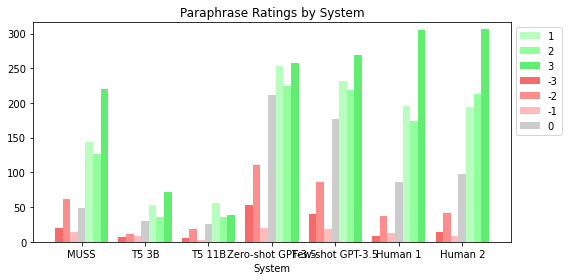

In [ ]:
ratings_by_edit_type(data, 'paraphrase')
# ratings_by_edit_type(data, 'split')
# ratings_by_edit_type(data, 'reorder')
# ratings_by_edit_type(data, 'structure')

In [ ]:
# Prints a table quality edits
for family in ['elaboration', 'generalization', 'split', 'structure', 'reorder', 'paraphrase']:
    ratings = get_ratings_by_edit_type(data, family)
    al = f'{family} & '
    for system in [s for s in all_system_labels if s in ratings.keys() and '2' not in s]:
        total = sum([x if type(x) is int else sum(x.values()) for x in list(ratings[system].values())])
        nl = ""
        for i in range(3):
            nl += (f'{round(ratings[system]["error"][i] / total, 2)*100:.0f} & ')
        nl += (f'{round(ratings[system]["trivial"] / total, 2)*100:.0f} & ')
        for i in range(3):
            nl += (f'{round(ratings[system]["quality"][i] / total, 2)*100:.0f} & ')
        al += nl
    al = ' & ' + al[:-2].capitalize() + '\\tabularnewline'
    print(al)

 & Elaboration & 0 & 14 & 15 & 5 & 38 & 23 & 5 & 0 & 2 & 8 & 9 & 65 & 12 & 5 & 0 & 14 & 5 & 11 & 59 & 5 & 5 & 0 & 5 & 3 & 4 & 58 & 24 & 6 & 0 & 4 & 2 & 7 & 55 & 26 & 7 & 0 & 5 & 2 & 2 & 52 & 23 & 16 \tabularnewline
 & Generalization & 0 & 29 & 11 & 0 & 0 & 37 & 23 & 0 & 24 & 13 & 0 & 0 & 37 & 26 & 0 & 30 & 15 & 0 & 0 & 35 & 21 & 0 & 12 & 2 & 0 & 0 & 42 & 44 & 0 & 13 & 1 & 0 & 0 & 37 & 49 & 0 & 14 & 2 & 0 & 0 & 42 & 42 \tabularnewline
 & Split & 0 & 0 & 2 & 6 & 29 & 32 & 31 & 0 & 2 & 1 & 1 & 26 & 36 & 34 & 0 & 0 & 1 & 0 & 35 & 28 & 36 & 0 & 0 & 2 & 0 & 33 & 31 & 33 & 0 & 0 & 1 & 0 & 33 & 32 & 34 & 0 & 1 & 1 & 0 & 28 & 38 & 31 \tabularnewline
 & Structure & 0 & 4 & 4 & 20 & 40 & 14 & 19 & 0 & 4 & 1 & 27 & 46 & 12 & 11 & 0 & 3 & 8 & 29 & 39 & 11 & 11 & 0 & 5 & 5 & 15 & 38 & 22 & 14 & 0 & 3 & 3 & 13 & 40 & 21 & 18 & 0 & 3 & 3 & 15 & 38 & 23 & 18 \tabularnewline
 & Reorder & 0 & 6 & 10 & 16 & 39 & 25 & 3 & 0 & 17 & 0 & 17 & 28 & 28 & 11 & 0 & 0 & 0 & 0 & 57 & 29 & 14 & 0 & 5 & 5 & 17 & 39 &

In [ ]:
# - Average quality edit (or log-size * average) rating for these modification types
#     - Content, Syntax, Lexical
#     - Elaboration, Generalization, Paraphrase, Structure, Reorder, Split
# - Average error edit for Content, Syntax, Lexical i guess?
# - Overlap the annotator’s decision for each system

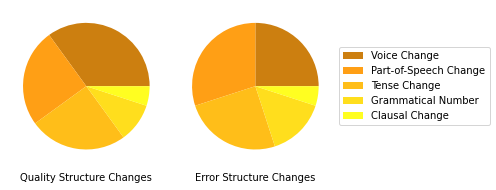

In [ ]:
subtypes = [
    'Voice Change',
    'Part-of-Speech Change',
    'Tense Change',
    'Grammatical Number',
    'Clausal Change'
]

fig, axs = plt.subplots(1, 2, figsize=(7, 3))
quality = np.array([35, 25, 25, 10, 5])
error = np.array([25, 30, 25, 15, 5])

color = color_mapping['structure']
scalar = [0.8, 1, 1.2, 1.4, 1.6]
colors = []
for s in scalar:
    colors += [colorscale(color, s)]

axs[0].pie(quality, colors=colors, labels=subtypes, labeldistance=None)
axs[1].pie(error, colors=colors, labels=subtypes, labeldistance=None)

axs[0].set_xlabel('Quality Structure Changes')
axs[1].set_xlabel('Error Structure Changes')
axs[1].legend(subtypes, loc='center left', bbox_to_anchor=(1, 0.5))
# plt.suptitle("Manual Breakdown of Structure Changes")

out_filename = "../paper/plot/appendix/structure-breakdown.pdf"
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show() 

DEBUG:Assigning font /F1 = 'C:\\Users\\heine\\AppData\\Roaming\\Python\\Python39\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'
DEBUG:Embedding font C:\Users\heine\AppData\Roaming\Python\Python39\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans.ttf.
DEBUG:Writing TrueType font.


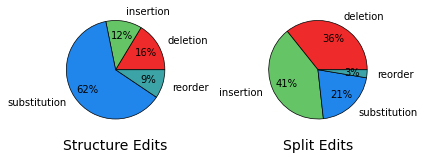

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

wedgeprops = {
    "edgecolor" : "black",
    'linewidth': 0.7,
    'antialiased': True
}

labels, values = zip(*count_dataset_composite_edits(data, 'structure').items())
axs[0].pie(values, colors=[color_mapping[l] for l in labels], labels=labels, labeldistance=1.2, \
    wedgeprops=wedgeprops, autopct='%1.f%%', pctdistance=0.7, textprops={'fontsize': 10})

labels, values = zip(*count_dataset_composite_edits(data, 'split').items())
axs[1].pie(values, colors=[color_mapping[l] for l in labels], labels=labels, labeldistance=1.2, \
    wedgeprops=wedgeprops, autopct='%1.f%%', pctdistance=0.7, textprops={'fontsize': 10})

axs[0].set_xlabel('Structure Edits', fontsize=14)
axs[1].set_xlabel('Split Edits', fontsize=14)
# plt.suptitle("Child Edits of Composite Edits")

# axs[1].legend([x.capitalize() for x in labels], loc='center left', bbox_to_anchor=(1, 0.5),
#     handlelength=1,handleheight=1,facecolor='white')

out_filename = "../paper/plot/appendix/composite-breakdown.pdf"
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)
plt.show() 

In [ ]:
class Quality_Condition(Enum):
    ELABORATION='Elaboration'
    GENERALIZATION='Generalization'
    WORD_REORDER='Word-level Reorder'
    COMPONENT_REORDER='Component-level Reorder'
    SPLIT='Sentence Split'
    STRUCTURE='Structure Change'
    PARAPHRASE='Paraphrase'

class Error_Condition(Enum):
    BAD_DELETION='Bad Deletion'
    COREFERENCE='Coreference'
    REPETITION='Repetition'
    CONTRADICTION='Contradiction'
    FACTUAL_ERROR='Factual Error'
    IRRELEVANT='Irrelevant'
    BAD_WORD_REORDER='Bad Word-level Reorder'
    BAD_COMPONENT_REORDER='Bad Component-level Reorder'
    BAD_STRUCTURE='Bad Structure Change'
    BAD_SPLIT='Bad Sentence Split'
    COMPLEX_WORDING='Complex Wording'
    INFORMATION_REWRITE='Information Rewrite'
    GRAMMAR='Grammar Error'

class Trivial_Condition(Enum):
    TRIVIAL="Trivial Insertion"

In [ ]:
def get_edits_from_condition(edits, condition):
    if condition == Quality_Condition.ELABORATION:
        return [e for e in edits if 
            e['information_impact'] == Information.MORE and
            e['type'] == Quality.QUALITY
        ]
    elif condition == Quality_Condition.GENERALIZATION:
        return [e for e in edits if 
            e['information_impact'] == Information.LESS and
            e['type'] == Quality.QUALITY
        ]
    elif condition == Quality_Condition.PARAPHRASE:
        return [e for e in edits if 
            e['information_impact'] == Information.SAME and
            e['edit_type'] == 'substitution' and
            e['type'] == Quality.QUALITY
        ]
    
    elif condition == Quality_Condition.SPLIT:
        return [e for e in edits if 
            e['edit_type'] == 'split' and
            e['type'] == Quality.QUALITY
        ]
    
    elif condition == Quality_Condition.WORD_REORDER:
        return [e for e in edits if 
            e['edit_type'] == 'reorder' and
            e['reorder_level'] == ReorderLevel.WORD and
            e['type'] == Quality.QUALITY
        ]
    
    elif condition == Quality_Condition.COMPONENT_REORDER:
        return [e for e in edits if 
            e['edit_type'] == 'reorder' and
            e['reorder_level'] == ReorderLevel.COMPONENT and
            e['type'] == Quality.QUALITY
        ]
    
    elif condition == Quality_Condition.STRUCTURE:
        return [e for e in edits if 
            e['edit_type'] == 'structure' and
            e['type'] == Quality.QUALITY
        ]

    if condition == Trivial_Condition.TRIVIAL:
        return [e for e in edits if 
            e['type'] == Quality.TRIVIAL
        ]

    edits = [e for e in edits if e['type'] == Quality.ERROR]

    if condition == Error_Condition.CONTRADICTION:
        return [e for e in edits if 
            e['error_type'] == Error.CONTRADICTION
        ]
    elif condition == Error_Condition.FACTUAL_ERROR:
        return [e for e in edits if 
            e['error_type'] == Error.FACTUAL
        ]
        
    elif condition == Error_Condition.IRRELEVANT:
        return [e for e in edits if 
            e['error_type'] == Error.IRRELEVANT
        ]

    elif condition == Error_Condition.REPETITION:
        return [e for e in edits if 
            e['error_type'] == Error.REPETITION
        ]
        
    elif condition == Error_Condition.BAD_DELETION:
        return [e for e in edits if 
            e['error_type'] == Error.BAD_DELETION
        ]
        
    elif condition == Error_Condition.COREFERENCE:
        return [e for e in edits if 
            e['error_type'] == Error.COREFERENCE
        ]
        
    elif condition == Error_Condition.INFORMATION_REWRITE:
        return [e for e in edits if 
            e['error_type'] == Error.INFORMATION_REWRITE
        ]
        
    elif condition == Error_Condition.BAD_SPLIT:
        return [e for e in edits if 
            e['error_type'] == Error.BAD_SPLIT
        ]
        
    elif condition == Error_Condition.BAD_WORD_REORDER:
        return [e for e in edits if 
            e['error_type'] == Error.BAD_REORDER and
            e['reorder_level'] == ReorderLevel.WORD 
        ]
        
    elif condition == Error_Condition.BAD_COMPONENT_REORDER:
        return [e for e in edits if 
            e['error_type'] == Error.BAD_REORDER and
            e['reorder_level'] == ReorderLevel.COMPONENT 
        ]
        
    elif condition == Error_Condition.BAD_STRUCTURE:
        return [e for e in edits if 
            e['error_type'] == Error.BAD_STRUCTURE
        ]
        
    elif condition == Error_Condition.COMPLEX_WORDING:
        return [e for e in edits if 
            e['error_type'] == Error.COMPLEX_WORDING
        ]        
    elif condition == Error_Condition.GRAMMAR:
        return [e for e in edits if 
            e['grammar_error'] == True
        ]
        

In [ ]:
table = ''

all_edits = [i for j in [s['processed_annotations'] for s in data] for i in j]

# Quality edits
table += '\\multirow{7}{*}{\\rotatebox[origin=c]{90}{Quality Evaluation}}'
for condition in Quality_Condition:
    edits = get_edits_from_condition(all_edits, condition)
    table += f' & {condition.value} & {len(edits)} & {sum([x["token_size"] for x in edits])} & {avg([x["rating"] for x in edits], prec=2)} \\\\\n'

table += '\\\midrule\n\\multirow{15}{*}{\\rotatebox[origin=c]{90}{Error Evaluation}}'

for condition in Error_Condition:
    edits = get_edits_from_condition(all_edits, condition)
    table += f' & {condition.value} & {len(edits)} & {sum([x["token_size"] for x in edits])} & {-avg([x["rating"] for x in edits if x["rating"] is not None], prec=2)} \\\\\n'

edits = get_edits_from_condition(all_edits, Trivial_Condition.TRIVIAL)
table += f'\\\midrule\n & Trivial Change & {len(edits)} & {sum([x["token_size"] for x in edits])} & {0} \\\\\n'

print(table)

\multirow{7}{*}{\rotatebox[origin=c]{90}{Quality Evaluation}} & Elaboration & 1431 & 3654 & 0.24 \\
 & Generalization & 2226 & 9228 & 0.52 \\
 & Word-level Reorder & 58 & 658 & 0.6 \\
 & Component-level Reorder & 689 & 6143 & 0.62 \\
 & Sentence Split & 1379 & 5868 & 0.72 \\
 & Structure Change & 1651 & 9173 & 0.47 \\
 & Paraphrase & 3400 & 14530 & 0.69 \\
\hline
\multirow{14}{*}{\rotatebox[origin=c]{90}{Error Evaluation}} & Bad Deletion & 629 & 4308 & -0.66 \\
 & Coreference & 9 & 42 & -0.89 \\
 & Repetition & 73 & 306 & -0.41 \\
 & Contradiction & 3 & 18 & -1.67 \\
 & Factual Error & 53 & 320 & -1.13 \\
 & Irrelevant & 36 & 229 & -0.75 \\
 & Bad Word-level Reorder & 13 & 102 & -0.54 \\
 & Bad Component-level Reorder & 186 & 1958 & -0.81 \\
 & Bad Structure Change & 209 & 1424 & -0.53 \\
 & Bad Sentence Split & 111 & 621 & -0.97 \\
 & Complex Wording & 453 & 1850 & -0.44 \\
 & Information Rewrite & 130 & 749 & -0.62 \\
 & Grammar Error & 58 & 333 & -0.97 \\
\hline
 & Trivial Change & 